- System 07 from the VADER dataset
- All available data (>3yrs)

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from clearsky.utilities import make_time_series
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
from datetime import datetime

In [8]:
from os.path import expanduser
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')

In [9]:
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')

In [10]:
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TADBC1078041')
        and meas_name = 'ac_power';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)

In [11]:
df = make_time_series(df, return_keys=False).fillna(0)

In [12]:
df.head()

ac_power_01
2015-04-24 15:10:00       0.3182
2015-04-24 15:15:00       0.3361
2015-04-24 15:20:00       0.3929
2015-04-24 15:25:00       0.3947
2015-04-24 15:30:00       0.4539

In [13]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print(start, end)

2015-04-25 00:00:00 2018-11-15 00:00:00


In [14]:
end - start

Timedelta('1300 days 00:00:00')

Note data acquisition system errors (missing data) at the beginning of the data set. The algorithm is robust to errors like this, requiring no special filtering.

/Users/tadatoshi/.pyenv/versions/anaconda3-2018.12/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'kW')

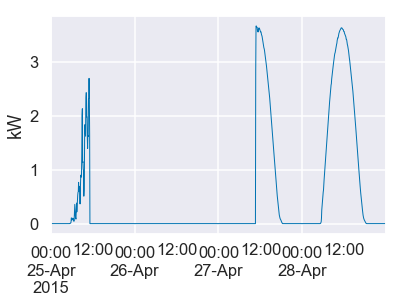

In [15]:
pa = PLOT_ARGS
pa['figsize'] = (6,4)
df.loc[start.strftime('%m/%d/%y'):(start + 3).strftime('%m/%d/%y')].plot(legend=False, **pa)
plt.ylabel('kW')

In [16]:
D = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')
p = df.loc[start:end]

In [17]:
U, Sig, Vt = np.linalg.svd(D, full_matrices=False)
U[:, 0] *= -1
Vt[0] *= -1

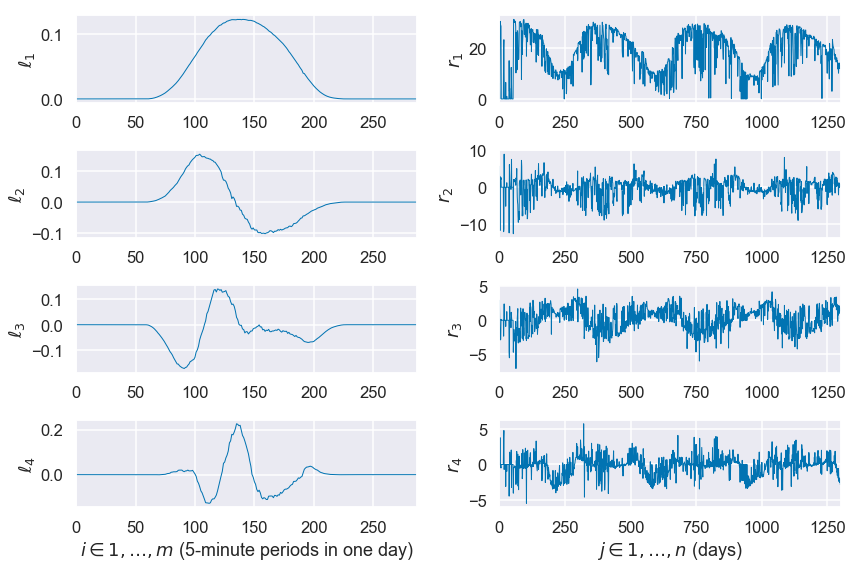

In [18]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,8))
for i in range(4):
    ax[i][0].plot(U.T[i], linewidth=1)
    ax[i][0].set_xlim(0, 287)
    ax[i][0].set_ylabel('$\\ell_{}$'.format(i+1))
    ax[i][1].plot((np.diag(Sig).dot(Vt))[i], linewidth=1)
    ax[i][1].set_xlim(0, D.shape[1])
    ax[i][1].set_ylabel('$r_{}$'.format(i+1))
ax[-1][0].set_xlabel('$i \\in 1, \\ldots, m$ (5-minute periods in one day)')
ax[-1][1].set_xlabel('$j \\in 1, \\ldots, n$ (days)')
plt.tight_layout()
plt.show()

In [19]:
IterativeClearSky.minimize_objective??

In [20]:
ics = IterativeClearSky(D, k=6)

In [21]:
import sys
np.set_printoptions(threshold=sys.maxsize)
ics.weights

array([0.        , 0.        , 0.        , 0.98278423, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.95361793,
       0.96814032, 0.91745032, 0.92983842, 0.90812385, 0.95871471,
       0.90748834, 0.90840462, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [22]:
ics.weights[100:104]

array([0.        , 0.97870261, 0.93385772, 0.        ])

In [23]:
#np.savetxt('weights_1.csv', ics.weights, delimiter=',')

In [24]:
initial_l_cs_value = ics.L_cs.value
initial_l_cs_value

array([[-0.00000000e+00, -2.22044605e-16,  3.88578059e-16,
         3.40005801e-16,  9.43689571e-16, -2.77555756e-16],
       [-0.00000000e+00,  2.77555756e-16, -5.55111512e-17,
         1.87350135e-16, -1.63757896e-15,  1.05471187e-15],
       [-0.00000000e+00,  0.00000000e+00,  5.55111512e-17,
         1.11022302e-16,  2.77555756e-16, -1.38777878e-16],
       [-0.00000000e+00,  0.00000000e+00, -1.11022302e-16,
        -2.77555756e-17,  9.71445147e-17, -1.04083409e-17],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         8.32667268e-17,  0.00000000e+00,  5.55111512e-17],
       [-0.00000000e+00,  0.00000000e+00, -6.93889390e-18,
         1.11022302e-16,  0.00000000e+00,  2.77555756e-17],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  4.16333634e-17],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00,  0.000

In [25]:
initial_l_cs_value.shape

(288, 6)

In [26]:
#np.savetxt('initial_l_cs_value_1.txt', initial_l_cs_value, delimiter=',')

In [27]:
initial_l_cs_value[144:148,:4]

array([[ 0.12227644, -0.05536519, -0.02796016,  0.11115515],
       [ 0.12183656, -0.06418167, -0.03631565,  0.09248578],
       [ 0.12190038, -0.07035386, -0.03077544,  0.06306368],
       [ 0.12185763, -0.0822263 , -0.02468169,  0.03843156]])

In [28]:
initial_r_cs_value = ics.R_cs.value
initial_r_cs_value

array([[ 5.95245601e+00, -7.98242425e-14,  1.99142432e+01,
         3.04881469e+01,  2.93032937e+01,  2.89535244e+01,
         2.85655124e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.00102607e+01,  2.32744600e+01,
         8.01840202e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  8.60655539e-04,
         6.48792593e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00474298e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.50309147e+01,  3.04174315e+00,
         4.11986418e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.03338333e-01,
         1.23581031e+01,  5.40375621e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [29]:
initial_r_cs_value.shape

(6, 1300)

In [30]:
#np.savetxt('initial_r_cs_value_1.csv', initial_r_cs_value, delimiter=',')

In [31]:
initial_r_cs_value[0:4,213:217]

array([[ 7.81948013, 11.26965908, 11.43521789,  8.89706298],
       [ 0.18783052, -1.17162576, -1.68541257, -1.14962881],
       [ 0.97275831,  0.99957452,  0.92734892,  0.453427  ],
       [-0.86265428, -3.28835462, -4.00326343, -1.76664483]])

In [32]:
ics.beta.value

0.0

In [33]:
ics.r0

array([29.0347036 , 29.0185262 , 29.00233706, 28.9861128 , 28.96981832,
       28.95352385, 28.93740498, 28.92169378, 28.90661054, 28.89236393,
       28.87915096, 28.86715692, 28.85655535, 28.84750805, 28.84016511,
       28.83466489, 28.83113412, 28.82968787, 28.83042947, 28.83345045,
       28.83883066, 28.8466383 , 28.85692988, 28.86975019, 28.88513229,
       28.90309758, 28.92365567, 28.94680449, 28.97253029, 29.0008076 ,
       29.03159926, 29.06485641, 29.10051847, 29.13851316, 29.1787565 ,
       29.22115278, 29.2655946 , 29.31196288, 29.36012686, 29.40994401,
       29.46126008, 29.51390915, 29.56771357, 29.62248401, 29.67801941,
       29.73410704, 29.79052248, 29.84702956, 29.90338039, 29.9593154 ,
       30.01456332, 30.06884116, 30.1218542 , 30.17329601, 30.22284854,
       30.270182  , 30.31507193, 30.35739917, 30.39714997, 30.43429886,
       30.46892579, 30.50109896, 30.53096624, 30.55866376, 30.58431588,
       30.60803539, 30.6299233 , 30.65006892, 30.6685498 , 30.68

In [34]:
#np.savetxt('initial_r0_value_1.csv', ics.r0, delimiter=',')

In [35]:
ics.mu_L = 5e2
ics.mu_R = 1e3
ics.tau = 0.9
ics.minimize_objective(max_iter=10)

starting at 528755.759 [2171.1759047049295, 183.68448929381688, 388776.7729609732, 137624.12552820993]
iteration 1: 2139.783 [1911.906   20.31   207.567    0.   ]
iteration 2: 1828.810 [1613.93   18.43  196.45    0.  ]
iteration 3: 1805.684 [1588.336   22.643  194.704    0.   ]
iteration 4: 1799.225 [1580.448   24.68   194.096    0.   ]
iteration 5: 1795.426 [1576.93    25.667  192.828    0.   ]
iteration 6: 1792.962 [1575.616   26.311  191.036    0.   ]
iteration 7: 1791.097 [1574.83    26.788  189.479    0.   ]
iteration 8: 1789.433 [1574.099   27.27   188.064    0.   ]
Minimization complete in 5.33 minutes


In [36]:
ics.L_cs.value

array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.000

In [37]:
#np.savetxt('l_cs_value_after_iteration_1_1.csv', ics.L_cs.value, delimiter=',')

In [38]:
ics.L_cs.value.shape

(288, 6)

In [39]:
ics.L_cs.value[144:148,:]

array([[ 0.12512953, -0.02932495,  0.01116636,  0.09034724, -0.04962102,
         0.07542998],
       [ 0.12499277, -0.0456209 , -0.00291031,  0.06317393, -0.06566858,
         0.06963326],
       [ 0.12538559, -0.06130657, -0.0151438 ,  0.03770746, -0.08124601,
         0.06118258],
       [ 0.12579746, -0.0749434 , -0.0260855 ,  0.01406965, -0.09592809,
         0.05087855]])

In [40]:
ics.R_cs.value

array([[ 3.17921080e+01,  3.18577361e+01,  3.19202112e+01,
         3.19796336e+01,  3.20361048e+01,  3.20896849e+01,
         3.21404344e+01,  3.21884426e+01,  3.22337467e+01,
         3.22763326e+01,  3.23160851e+01,  3.23529035e+01,
         3.23866642e+01,  3.24172439e+01,  3.24445191e+01,
         3.24687101e+01,  3.24900373e+01,  3.25087210e+01,
         3.25249815e+01,  3.25390068e+01,  3.25509354e+01,
         3.25609059e+01,  3.25690567e+01,  3.25755265e+01,
         3.25804537e+01,  3.25839770e+01,  3.25861923e+01,
         3.25871492e+01,  3.25868972e+01,  3.25854339e+01,
         3.25827134e+01,  3.25786478e+01,  3.25731494e+01,
         3.25661303e+01,  3.25575028e+01,  3.25471790e+01,
         3.25350658e+01,  3.25210697e+01,  3.25050976e+01,
         3.24870561e+01,  3.24668521e+01,  3.24445050e+01,
         3.24200346e+01,  3.23934119e+01,  3.23646080e+01,
         3.23335939e+01,  3.23003673e+01,  3.22649209e+01,
         3.22272909e+01,  3.21875132e+01,  3.21455711e+0

In [41]:
#np.savetxt('r_cs_value_after_iteration_1_1.csv', ics.R_cs.value, delimiter=',')

In [42]:
ics.R_cs.value.shape

(6, 1300)

In [43]:
ics.R_cs.value[0:4,213:217]

array([[11.55420597, 11.40352743, 11.26227534, 11.13044755],
       [ 0.74013225,  0.68916652,  0.63936241,  0.59080774],
       [ 4.25299812,  4.24131483,  4.23155089,  4.2237806 ],
       [-3.43218373, -3.46367401, -3.49114979, -3.51451865]])

In [44]:
ics.beta.value

array(-0.04215127)

In [51]:
type(ics.beta.value)

numpy.ndarray

In [53]:
ics.beta.value.shape

()

In [49]:
clear_sky_signals = ics.L_cs.value.dot(ics.R_cs.value)
clear_sky_signals

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [50]:
np.savetxt('clear_sky_signals_result_1.txt', clear_sky_signals, delimiter=',')

In [55]:
ics.weights.shape


(1300,)

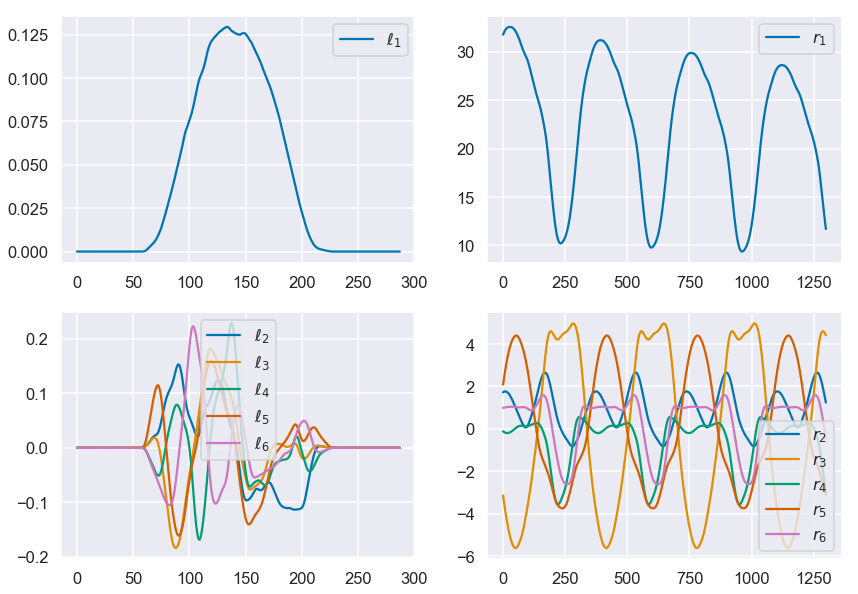

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(ics.R_cs.value[0])
ax[1, 1].plot(ics.R_cs.value[1:].T)
ax[0, 0].plot(ics.L_cs.value[:, 0])
ax[1, 0].plot(ics.L_cs.value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
plt.show()

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [46]:
ics.beta.value

array(-0.04215127)

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,4), sharex=True)
    foo = ax[0].imshow(ics.D, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot',
                       vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW', ticks=range(5))
    plt.colorbar(bar, ax=ax[1], label='kW', ticks=range(5))
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

In [ ]:
D1 = 340
D2 = D1 + 2
actual = p[D1*288:D2*288].values
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(D2-D1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

In [ ]:
print(sum(ics.L_cs.shape) + sum(ics.R_cs.shape))

In [ ]:
D1 = 220
D2 = D1+5
actual = p[D1*288:D2*288].values
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(ics.weights[D1:D2], 288), linewidth=1)
ax[1].set_xlim(0, 288*(D2-D1))

In [ ]:
ics.beta.value

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(D, axis=0), linewidth=1)
plt.plot(ics.R_cs.value[0] * np.sum(ics.L_cs.value[:, 0]), linewidth=1)

In [ ]:
residuals1 = ics.R_cs.value[0] * np.sum(ics.L_cs.value[:, 0]) - np.sum(D, axis=0)
plt.figure(figsize=(12,8))
plt.plot(residuals1, linewidth=1)

In [ ]:
ics2 = IterativeClearSky(D, k=6)
ics2.mu_L = 5e2
ics2.mu_R = 1e3
ics2.tau = 0.9
ics2.minimize_objective(max_iter=10, calc_deg=False)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(ics2.R_cs.value[0])
ax[1, 1].plot(ics2.R_cs.value[1:].T)
ax[0, 0].plot(ics2.L_cs.value[:, 0])
ax[1, 0].plot(ics2.L_cs.value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, ics2.R_cs.value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, ics2.R_cs.value.shape[0]+1)])
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(D, axis=0), linewidth=1)
plt.plot(ics2.R_cs.value[0] * np.sum(ics2.L_cs.value[:, 0]), linewidth=1)

In [ ]:
residuals2 = ics2.R_cs.value[0] * np.sum(ics2.L_cs.value[:, 0]) - np.sum(D, axis=0)
plt.figure(figsize=(12,8))
plt.plot(residuals2, linewidth=1)

In [ ]:
plt.hist(-residuals1, bins=50, alpha=0.5, label='with deg')
plt.hist(-residuals2, bins=50, alpha=0.5, label='no deg')
plt.axvline(np.median(-residuals1), color='b', label='median with deg', ls='--')
plt.axvline(np.median(-residuals2), color='g', label='median no deg', ls='--')
plt.xlim(-200, 50)
plt.legend()
plt.show()

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=3, figsize=(8,6), sharex=True)
    foo = ax[0].imshow(ics.D, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot',
                       vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power, with deg')
    fbr = ax[2].imshow(ics2.L_cs.value.dot(ics2.R_cs.value), cmap='hot',
                       vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[2].set_title('Estimated clear sky power, no deg')
    plt.colorbar(foo, ax=ax[0], label='kW', ticks=range(5))
    plt.colorbar(bar, ax=ax[1], label='kW', ticks=range(5))
    plt.colorbar(fbr, ax=ax[2], label='kW', ticks=range(5))
    ax[-1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    ax[2].set_yticks([])
    ax[2].set_ylabel('Time of day')
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.sum(D, axis=0) * 5/60, linewidth=1, label='measured')
plt.plot(ics.R_cs.value[0] * np.sum(ics.L_cs.value[:, 0]) * 5/60, linewidth=1, label='clear sky, with deg')
plt.plot(ics2.R_cs.value[0] * np.sum(ics2.L_cs.value[:, 0]) * 5/60, linewidth=1, label='clear sky, no deg')
plt.ylim(-2, 40)
plt.legend(loc=1)
plt.title('Daily Energy')
plt.xlabel('day number')
plt.ylabel('kWh')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(residuals1)), -residuals1, marker='.', alpha=0.5, label='clear sky, with deg')
plt.scatter(range(len(residuals2)), -residuals2, marker='.', alpha=0.5, label='clear sky, no deg')
plt.ylim(-100, 30)
plt.legend(loc=1)
plt.title('Daily Energy Residuals')
plt.xlabel('day number')
plt.ylabel('kWh')
plt.show()